In [1]:
import os 
# Check the current directory
print("Current directory:", os.getcwd())

# Change to the folder containing NanoAOD ROOT files
os.chdir("C:\\MAIN\\HSF-India\\MC_samples_final")
# os.chdir("C:\\MAIN\\HSF-India\\Test_samples")

# Confirm the change
print("\nNew working directory:", os.getcwd())

for file in os.listdir():
    print(f'{file}')

Current directory: c:\MAIN\HSF-India\Txt_file\HIggs

New working directory: C:\MAIN\HSF-India\MC_samples_final
Diboson.root
DY.root
files.txt
Higgs.root
Single_top.root
TTBar.root
Wjets.root


In [2]:
import uproot                          # For reading ROOT files                    
import awkward as ak                   # For handling jagged arrays
import numpy as np                     # For numerical operations
import matplotlib.pyplot as plt        # For plotting
import vector                          # For vector operations
from hist import Hist                  # For histogramming
from tqdm import tqdm                  # For progress bars
import gc                              # For garbage collection
%matplotlib inline

# Register vector support for awkward arrays
vector.register_awkward()

In [3]:
# Unified sample configuration - single source of truth
SAMPLES = {
    "signal": {
        "color": "#EC2424",  # Strong red
        "is_signal": True,
        "stack_order": None
    },
    "DY_to_Tau_Tau": {
        "color": "#0C3AA5",  # Deep blue
        "is_signal": False,
        "stack_order": 0
    },
    "Wjets": {
        "color": "#23D9ED",  # Teal
        "is_signal": False,
        "stack_order": 1
    },
    "Top_antitop": {
        "color": "#29B829",  # Dark green
        "is_signal": False,
        "stack_order": 2
    },
    "Single_Top": {
        "color": "#B26EF1",  # Purple
        "is_signal": False,
        "stack_order": 3
    },
    "Diboson": {
        "color": "#DDB340",  # Mustard
        "is_signal": False,
        "stack_order": 4
    }
}


In [4]:
# Extract colors for backward compatibility
colors = {key: value["color"] for key, value in SAMPLES.items()}


In [5]:
# %%
# Load file names from file
files = {}
with open("files.txt", "r") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        key, filename = line.split(maxsplit=1)
        files[key] = filename

print("Files to process:")
for key, file in files.items():
    print(f"{key}: {file}")

Files to process:
signal: Higgs.root
DY_to_Tau_Tau: DY.root
Top_antitop: TTBar.root
Diboson: Diboson.root
Single_Top: Single_top.root
Wjets: Wjets.root


In [6]:
# %%
def wrap_angle_to_pi(angle):
    """More concise way to wrap angle to [-π, π] range"""
    return (angle + np.pi) % (2 * np.pi) - np.pi

def create_lepton_vector(lepton):
    """Create 4-vector from lepton properties - unified function"""
    return vector.array({
        "pt": lepton.pt,
        "eta": lepton.eta,
        "phi": lepton.phi,
        "mass": lepton.mass
    })

In [7]:
# %%
def load_events(filename, batch_size=100_000):
    """Load events from a ROOT file in batches"""
    print(f"\nProcessing: {filename}")

    columns = [
        # Electrons
        "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", 
        "Electron_mvaFall17V2Iso_WP90", "Electron_charge",
        # Muons
        "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", 
        "Muon_tightId", "Muon_charge", "Muon_pfRelIso04_all",
        # MET
        "MET_pt", "MET_phi",
        # Jets
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
        "Jet_btagDeepFlavB", "nJet", "Jet_jetId", "Jet_puId",
    ]

    with uproot.open(filename) as f:
        tree = f['Events']
        total_entries = tree.num_entries
        print(f"Total events: {total_entries}")

        num_batches = (total_entries + batch_size - 1) // batch_size
        
        pbar = tqdm(
            tree.iterate(columns, step_size=batch_size, library="ak"),
            total=num_batches,
            desc="Processing batches",
            unit="batch",
            ncols=100
        )
        
        for batch_num, arrays in enumerate(pbar):
            pbar.set_postfix({
                'events': f"{len(arrays):,}",
                'batch': f"{batch_num + 1}/{num_batches}"
            })
            yield arrays

In [8]:

# %%
def select_tight_leptons(arrays):
    """Apply tight ID and isolation cuts to leptons"""
    # Define selection masks
    tight_electron_mask = arrays.Electron_mvaFall17V2Iso_WP90 == 1
    tight_muon_mask = (arrays.Muon_tightId == 1) & (arrays.Muon_pfRelIso04_all < 0.15)
    
    # Create structured arrays for selected leptons
    tight_electrons = ak.zip({
        "pt": arrays.Electron_pt[tight_electron_mask],
        "eta": arrays.Electron_eta[tight_electron_mask],
        "phi": arrays.Electron_phi[tight_electron_mask],
        "mass": arrays.Electron_mass[tight_electron_mask],
        "charge": arrays.Electron_charge[tight_electron_mask],
        "flavor": ak.ones_like(arrays.Electron_pt[tight_electron_mask]) * 11
    })
    
    tight_muons = ak.zip({
        "pt": arrays.Muon_pt[tight_muon_mask],
        "eta": arrays.Muon_eta[tight_muon_mask],
        "phi": arrays.Muon_phi[tight_muon_mask],
        "mass": arrays.Muon_mass[tight_muon_mask],
        "charge": arrays.Muon_charge[tight_muon_mask],
        "flavor": ak.ones_like(arrays.Muon_pt[tight_muon_mask]) * 13
    })
    
    # Combine into single collection
    tight_leptons = ak.concatenate([tight_electrons, tight_muons], axis=1)
    
    return tight_leptons, tight_electron_mask, tight_muon_mask

In [9]:
def select_e_mu_events(tight_leptons, met_arrays, leading_pt_cut=25, subleading_pt_cut=15):
    """Select events with exactly 1 electron and 1 muon"""
    
    # Sort by pT
    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
    
    # Require at least 2 leptons
    mask_2lep = ak.num(sorted_leptons) >= 2
    events_2lep = sorted_leptons[mask_2lep]
    met_2lep = met_arrays[mask_2lep]
    
    if len(events_2lep) == 0:
        return None, None, {}, None
    
    # Get leading and subleading
    leading = events_2lep[:, 0]
    subleading = events_2lep[:, 1]
    
    # Selection criteria
    mask_1e1mu = ((leading.flavor == 11) & (subleading.flavor == 13)) | \
                 ((leading.flavor == 13) & (subleading.flavor == 11))
    mask_opposite_charge = leading.charge * subleading.charge < 0
    mask_pt = (leading.pt > leading_pt_cut) & (subleading.pt > subleading_pt_cut)
    
    # Final selection
    final_mask = mask_1e1mu & mask_opposite_charge & mask_pt
    
    # Store cutflow information
    cutflow = {
        'events_2lep': len(leading),
        'events_1e1mu': ak.sum(mask_1e1mu),
        'events_opposite_charge': ak.sum(mask_1e1mu & mask_opposite_charge),
        'events_final': ak.sum(final_mask)
    }
    
    return leading[final_mask], subleading[final_mask], cutflow, met_2lep[final_mask]


In [10]:
def cal_inv_mass(leading, subleading):
    """Calculate e-mu invariant mass using unified vector function"""
    lepton_1 = create_lepton_vector(leading)
    lepton_2 = create_lepton_vector(subleading)
    
    dilepton = lepton_1 + lepton_2
    return dilepton.mass

def cal_dphill(leading, subleading):
    """Delta phi between two leptons, using unified angle wrapping"""
    dphi = leading.phi - subleading.phi
    return np.abs(wrap_angle_to_pi(dphi))

def cal_ptll(leading, subleading):
    """Calculate dilepton transverse momentum using unified vector function"""
    lep1_vec = create_lepton_vector(leading)
    lep2_vec = create_lepton_vector(subleading)
    
    dilepton = lep1_vec + lep2_vec
    return dilepton.pt

def calculate_mt_higgs(leading, subleading, met):
    """Calculate transverse mass of the Higgs candidate"""
    lep1 = create_lepton_vector(leading)
    lep2 = create_lepton_vector(subleading)
    
    dilepton = lep1 + lep2
    
    # Calculate dphi using unified angle wrapping
    dphi = wrap_angle_to_pi(dilepton.phi - met.phi)
    
    # Calculate transverse mass
    mt_higgs = np.sqrt(2 * dilepton.pt * met.pt * (1 - np.cos(dphi)))
    
    return mt_higgs

def calculate_mt_l2_met(subleading, met):
    """Calculate transverse mass between subleading lepton and MET"""
    # Calculate dphi using unified angle wrapping
    dphi = wrap_angle_to_pi(subleading.phi - met.phi)
    
    # Calculate transverse mass
    mt_l2_met = np.sqrt(2 * subleading.pt * met.pt * (1 - np.cos(dphi)))
    
    return mt_l2_met


In [11]:
def count_jets(arrays, jet_pt_threshold=30):
    """Count good jets above pt threshold"""
    # Good jet selection: jetId >= 2 (Tight ID)
    good_jet_mask = (arrays.Jet_jetId >= 2) & (arrays.Jet_pt > jet_pt_threshold)
    n_jets = ak.sum(good_jet_mask, axis=1)
    return n_jets, good_jet_mask

def apply_bjet_veto(arrays, bjet_pt_threshold=20, btag_threshold=0.3093):
    """Apply b-jet veto - returns True for events passing the veto (no b-jets)"""
    # Medium WP for DeepFlavB is typically ~0.3093
    bjet_mask = (arrays.Jet_pt > bjet_pt_threshold) & (arrays.Jet_btagDeepFlavB > btag_threshold)
    n_bjets = ak.sum(bjet_mask, axis=1)
    # Pass veto if no b-jets
    return n_bjets == 0

In [12]:
def apply_global_cuts(leading, subleading, met, mt_higgs, mt_l2_met):
    """Apply global selection cuts"""
    # Global cuts
    mask_subleading_pt = subleading.pt >= 20  # Already applied in preselection, but can be stricter
    mask_mt_higgs = mt_higgs > 60
    mask_mt_l2_met = mt_l2_met > 30
    
    # Combine all masks
    global_mask = mask_mt_higgs & mask_mt_l2_met
    
    return global_mask, {
        'pass_mt_higgs': ak.sum(mask_mt_higgs),
        'pass_mt_l2_met': ak.sum(mask_mt_l2_met),
        'pass_global': ak.sum(global_mask)
    }

In [13]:
# NEW: Initialize storage for different stages
def initialize_stage_storage():
    """Initialize storage for all selection stages"""
    return {
        'before_cuts': {},
        'global': {},
        '0jet': {},
        '1jet': {},
        '2jet': {}
    }


In [14]:
# %%
# Initialize data storage
hist_data = {}
selected_leptons = {}
event_variables = {}

# Define binning
mass_bins = np.linspace(0, 200, 25)
met_bins = np.linspace(0, 200, 25)
dphi_bins = np.linspace(0, np.pi, 25)
ptll_bins = np.linspace(0, 200, 25)

In [15]:
# Create storage for each sample
stage_data = {}
for label in files.keys():
    stage_data[label] = initialize_stage_storage()

In [16]:
def process_file_unified(fname, label):
    """Single processing function that handles all stages"""
    
    # Initialize collectors for all stages
    stage_collectors = {stage: {
        "mass": [], "met": [], "dphi": [], "ptll": [],
        "mt_higgs": [], "mt_l2_met": [],
        "leading": [], "subleading": []
    } for stage in ['before_cuts', 'global', '0jet', '1jet', '2jet']}
    
    # Cutflow tracking
    cutflow = {
        'total': 0,
        'e_mu_preselection': 0,
        'global_cuts': 0,
        '0jet': 0,
        '1jet': 0,
        '2jet': 0
    }
    
    print(f"\nProcessing: {fname}")
    
    # Process file in batches
    for arrays in load_events(fname, batch_size=100_000):
        cutflow['total'] += len(arrays)
        
        # Get tight leptons
        tight_leptons, _, _ = select_tight_leptons(arrays)
        met = ak.zip({"pt": arrays.MET_pt, "phi": arrays.MET_phi})
        
        # Apply e-mu selection
        leading, subleading, emu_cutflow, met_selected = select_e_mu_events(tight_leptons, met)
        
        if leading is None or len(leading) == 0:
            continue
            
        cutflow['e_mu_preselection'] += len(leading)
        
        # Calculate kinematic variables
        masses = cal_inv_mass(leading, subleading)
        dphis = cal_dphill(leading, subleading)
        ptlls = cal_ptll(leading, subleading)
        mt_higgs = calculate_mt_higgs(leading, subleading, met_selected)
        mt_l2_met = calculate_mt_l2_met(subleading, met_selected)
        
        # === STAGE 1: BEFORE_CUTS (after e-mu preselection) ===
        stage_collectors['before_cuts']["mass"].append(masses)
        stage_collectors['before_cuts']["met"].append(met_selected.pt)
        stage_collectors['before_cuts']["dphi"].append(dphis)
        stage_collectors['before_cuts']["ptll"].append(ptlls)
        stage_collectors['before_cuts']["mt_higgs"].append(mt_higgs)
        stage_collectors['before_cuts']["mt_l2_met"].append(mt_l2_met)
        stage_collectors['before_cuts']["leading"].append(leading)
        stage_collectors['before_cuts']["subleading"].append(subleading)
        
        # === STAGE 2: GLOBAL CUTS ===
        # To properly align jet information, we need to track which original events passed e-mu selection
        sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
        has_2lep = ak.num(sorted_leptons) >= 2
        
        # Recreate the e-mu selection mask at event level
        events_2lep = sorted_leptons[has_2lep]
        if len(events_2lep) > 0:
            lead_all = events_2lep[:, 0]
            sublead_all = events_2lep[:, 1]
            
            mask_1e1mu = ((lead_all.flavor == 11) & (sublead_all.flavor == 13)) | \
                         ((lead_all.flavor == 13) & (sublead_all.flavor == 11))
            mask_charge = lead_all.charge * sublead_all.charge < 0
            mask_pt = (lead_all.pt > 25) & (sublead_all.pt > 15)
            
            emu_mask_2lep = mask_1e1mu & mask_charge & mask_pt
            
            # Map back to original indices
            indices_2lep = ak.where(has_2lep)[0]
            indices_emu = indices_2lep[emu_mask_2lep]
            
            # Apply global cuts
            global_cut_mask = (mt_higgs > 60) & (mt_l2_met > 30)
            
            # Apply b-jet veto
            bjet_veto_full = apply_bjet_veto(arrays)
            bjet_veto_selected = bjet_veto_full[indices_emu]
            
            # Combine cuts
            global_mask_selected = global_cut_mask & bjet_veto_selected
            cutflow['global_cuts'] += ak.sum(global_mask_selected)
            
            # Store global stage data
            if ak.sum(global_mask_selected) > 0:
                stage_collectors['global']["mass"].append(masses[global_mask_selected])
                stage_collectors['global']["met"].append(met_selected.pt[global_mask_selected])
                stage_collectors['global']["dphi"].append(dphis[global_mask_selected])
                stage_collectors['global']["ptll"].append(ptlls[global_mask_selected])
                stage_collectors['global']["mt_higgs"].append(mt_higgs[global_mask_selected])
                stage_collectors['global']["mt_l2_met"].append(mt_l2_met[global_mask_selected])
                stage_collectors['global']["leading"].append(leading[global_mask_selected])
                stage_collectors['global']["subleading"].append(subleading[global_mask_selected])
                
                # === STAGES 3-5: JET CATEGORIES ===
                # Count jets for full events (FIXED: unpack tuple)
                n_jets_full, _ = count_jets(arrays)  # <-- THIS IS THE FIX
                n_jets_selected = n_jets_full[indices_emu]
                
                # Apply jet categories
                mask_0jet = global_mask_selected & (n_jets_selected == 0)
                mask_1jet = global_mask_selected & (n_jets_selected == 1)
                mask_2jet = global_mask_selected & (n_jets_selected >= 2)
                
                cutflow['0jet'] += ak.sum(mask_0jet)
                cutflow['1jet'] += ak.sum(mask_1jet)
                cutflow['2jet'] += ak.sum(mask_2jet)
                
                # Store jet category data
                for jet_cat, mask in [('0jet', mask_0jet), ('1jet', mask_1jet), ('2jet', mask_2jet)]:
                    if ak.sum(mask) > 0:
                        stage_collectors[jet_cat]["mass"].append(masses[mask])
                        stage_collectors[jet_cat]["met"].append(met_selected.pt[mask])
                        stage_collectors[jet_cat]["dphi"].append(dphis[mask])
                        stage_collectors[jet_cat]["ptll"].append(ptlls[mask])
                        stage_collectors[jet_cat]["mt_higgs"].append(mt_higgs[mask])
                        stage_collectors[jet_cat]["mt_l2_met"].append(mt_l2_met[mask])
                        stage_collectors[jet_cat]["leading"].append(leading[mask])
                        stage_collectors[jet_cat]["subleading"].append(subleading[mask])
        
        # Clear memory
        del arrays
        gc.collect()
    
    # Concatenate results
    final_data = {}
    for stage in stage_collectors:
        if stage_collectors[stage]["mass"]:
            final_data[stage] = {
                key: ak.concatenate(values) if values else ak.Array([])
                for key, values in stage_collectors[stage].items()
            }
        else:
            final_data[stage] = None
    
    # For backward compatibility, also create event_variables format using before_cuts data
    if final_data['before_cuts'] is not None:
        event_data = {
            "mass": final_data['before_cuts']["mass"],
            "met": final_data['before_cuts']["met"],
            "dphi": final_data['before_cuts']["dphi"],
            "ptll": final_data['before_cuts']["ptll"],
            "mt_higgs": final_data['before_cuts']["mt_higgs"],
            "mt_l2_met": final_data['before_cuts']["mt_l2_met"],
            "leading": final_data['before_cuts']["leading"],
            "subleading": final_data['before_cuts']["subleading"]
        }
    else:
        event_data = None
    
    return final_data, event_data, cutflow

In [17]:
        
stage_data_final = {}

In [18]:


# %%
# SINGLE PROCESSING LOOP
print("\n" + "="*60)
print("PROCESSING:")
print("="*60)

file_pbar = tqdm(files.items(), desc="Processing files", unit="file", ncols=100)

for label, fname in file_pbar:
    file_pbar.set_description(f"Processing {label}")
    
    try:
        # Process file once for all stages
        stage_data_final[label], event_variables[label], cutflow = process_file_unified(fname, label)
        
        # Print cutflow
        print(f"\n{label} Cutflow:")
        print(f"  Total events:       {cutflow['total']:,}")
        print(f"  e-μ preselection:   {cutflow['e_mu_preselection']:,}")
        print(f"  Global cuts:        {cutflow['global_cuts']:,}")
        print(f"  ├── 0-jet:          {cutflow['0jet']:,}")
        print(f"  ├── 1-jet:          {cutflow['1jet']:,}")
        print(f"  └── 2-jet:          {cutflow['2jet']:,}")
        
    except Exception as e:
        file_pbar.set_postfix({'ERROR': str(e)[:20]})
        print(f"\nError processing {fname}: {e}")
        import traceback
        traceback.print_exc()
        stage_data_final[label] = initialize_stage_storage()
        event_variables[label] = None

print("\nProcessing complete!")


PROCESSING:


Processing signal:   0%|                                                    | 0/6 [00:00<?, ?file/s]


Processing: Higgs.root

Processing: Higgs.root
Total events: 2838995


Processing DY_to_Tau_Tau:  17%|██████▏                              | 1/6 [00:35<02:58, 35.60s/file]


signal Cutflow:
  Total events:       2,838,995
  e-μ preselection:   187,533
  Global cuts:        117,841
  ├── 0-jet:          5,093
  ├── 1-jet:          48,584
  └── 2-jet:          64,164

Processing: DY.root

Processing: DY.root
Total events: 81632177


Processing Top_antitop:  33%|████████████▋                         | 2/6 [12:58<30:07, 451.77s/file]


DY_to_Tau_Tau Cutflow:
  Total events:       81,632,177
  e-μ preselection:   67,742
  Global cuts:        876
  ├── 0-jet:          12
  ├── 1-jet:          237
  └── 2-jet:          627

Processing: TTBar.root

Processing: TTBar.root
Total events: 42229000


Processing Diboson:  50%|█████████████████████                     | 3/6 [19:49<21:38, 432.98s/file]


Top_antitop Cutflow:
  Total events:       42,229,000
  e-μ preselection:   5,271,418
  Global cuts:        436,047
  ├── 0-jet:          823
  ├── 1-jet:          14,007
  └── 2-jet:          421,217

Processing: Diboson.root

Processing: Diboson.root
Total events: 11635000


Processing Single_Top:  67%|██████████████████████████             | 4/6 [21:12<09:49, 294.80s/file]


Diboson Cutflow:
  Total events:       11,635,000
  e-μ preselection:   300,975
  Global cuts:        158,371
  ├── 0-jet:          2,936
  ├── 1-jet:          32,622
  └── 2-jet:          122,813

Processing: Single_top.root

Processing: Single_top.root
Total events: 36080000


Processing Wjets:  83%|████████████████████████████████████▋       | 5/6 [26:05<04:54, 294.37s/file]


Single_Top Cutflow:
  Total events:       36,080,000
  e-μ preselection:   14,532
  Global cuts:        1,314
  ├── 0-jet:          5
  ├── 1-jet:          142
  └── 2-jet:          1,167

Processing: Wjets.root

Processing: Wjets.root
Total events: 65136783


Processing Wjets: 100%|████████████████████████████████████████████| 6/6 [32:58<00:00, 329.77s/file]


Wjets Cutflow:
  Total events:       65,136,783
  e-μ preselection:   1,108
  Global cuts:        457
  ├── 0-jet:          18
  ├── 1-jet:          166
  └── 2-jet:          273

Processing complete!


In [28]:
def plot_stage_comparison(variable, var_props, stage_data_all):
    """Create comparison plot across selection stages for a given variable"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Before cuts', 'Global cuts', '0-jet', '1-jet', '≥2-jet']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
        ax = axes[idx]
        
        # Plot each sample
        for sample in files.keys():
            if sample in stage_data_all and stage_data_all[sample][stage] is not None:
                if variable in stage_data_all[sample][stage]:
                    data = ak.to_numpy(stage_data_all[sample][stage][variable])
                    
                    if len(data) > 0:
                        ax.hist(data, bins=var_props['bins'], 
                               histtype='step', linewidth=2 if SAMPLES[sample]["is_signal"] else 1.5,
                               label=sample, color=SAMPLES[sample]["color"], alpha=0.8, density=True)
        
        ax.set_xlabel(var_props['xlabel'], fontsize=10)
        ax.set_title(stage_label, fontsize=11, fontweight='bold')
        ax.set_xlim(var_props['xlim'])
        
        if idx == 0:
            ax.set_ylabel('Events', fontsize=10)
            ax.legend(fontsize=8)
        
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{variable.upper()} Distribution Across Selection Stages', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

In [29]:
# Create comparison plots for each sample and variable
variables_to_plot = {
    'mass': {'bins': np.linspace(0, 200, 30), 'xlabel': '$m_{e\\mu}$ [GeV]', 'xlim': (0, 200)},
    'met': {'bins': np.linspace(0, 200, 30), 'xlabel': '$E_T^{miss}$ [GeV]', 'xlim': (0, 200)},
    'dphi': {'bins': np.linspace(0, np.pi, 30), 'xlabel': '$\\Delta\\phi_{e\\mu}$ [rad]', 'xlim': (0, np.pi)},
    'ptll': {'bins': np.linspace(0, 200, 30), 'xlabel': '$p_T^{e\\mu}$ [GeV]', 'xlim': (0, 200)},
    'mt_higgs': {'bins': np.linspace(0, 250, 30), 'xlabel': '$m_T^{H}$ [GeV]', 'xlim': (0, 250)},
    'mt_l2_met': {'bins': np.linspace(0, 200, 30), 'xlabel': '$m_T(\\ell_2, E_T^{miss})$ [GeV]', 'xlim': (0, 200)}
}



Creating comparison plots...

Plotting mass...


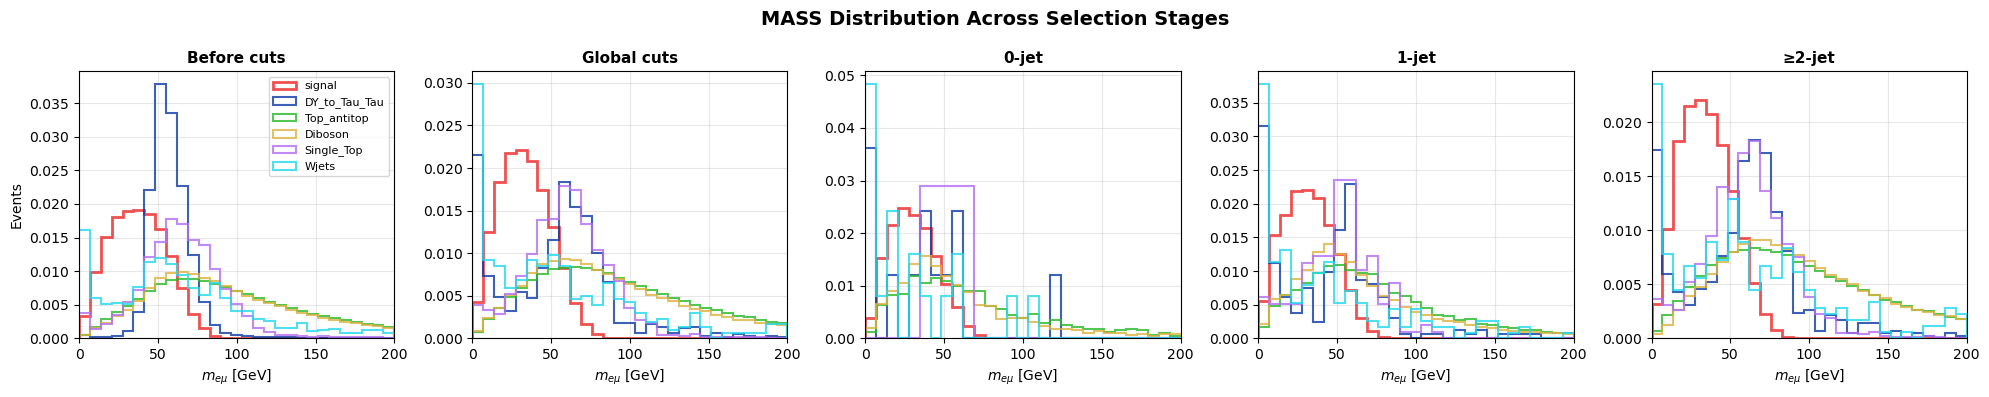


Plotting met...


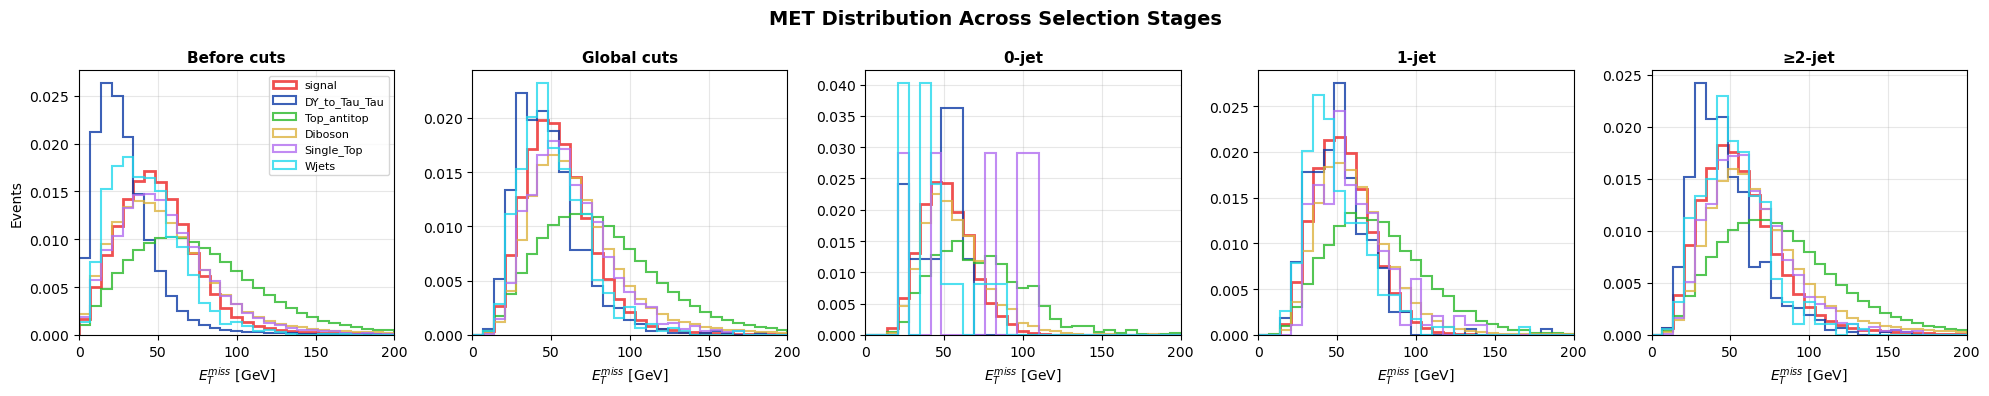


Plotting dphi...


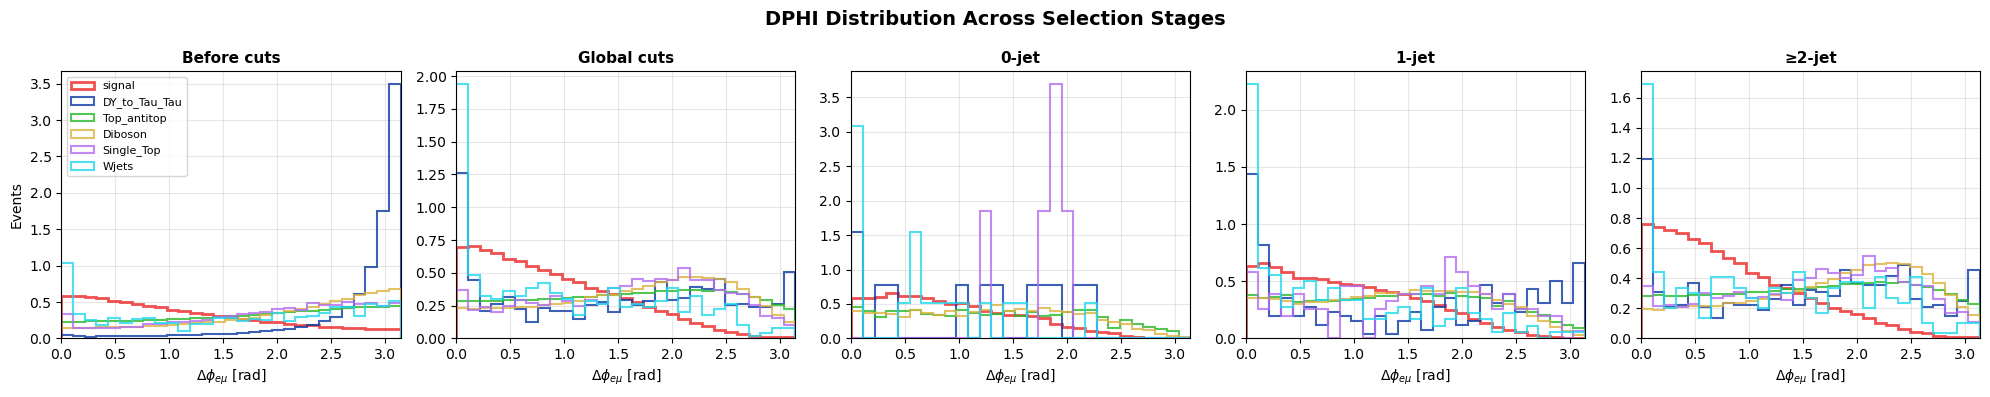


Plotting ptll...


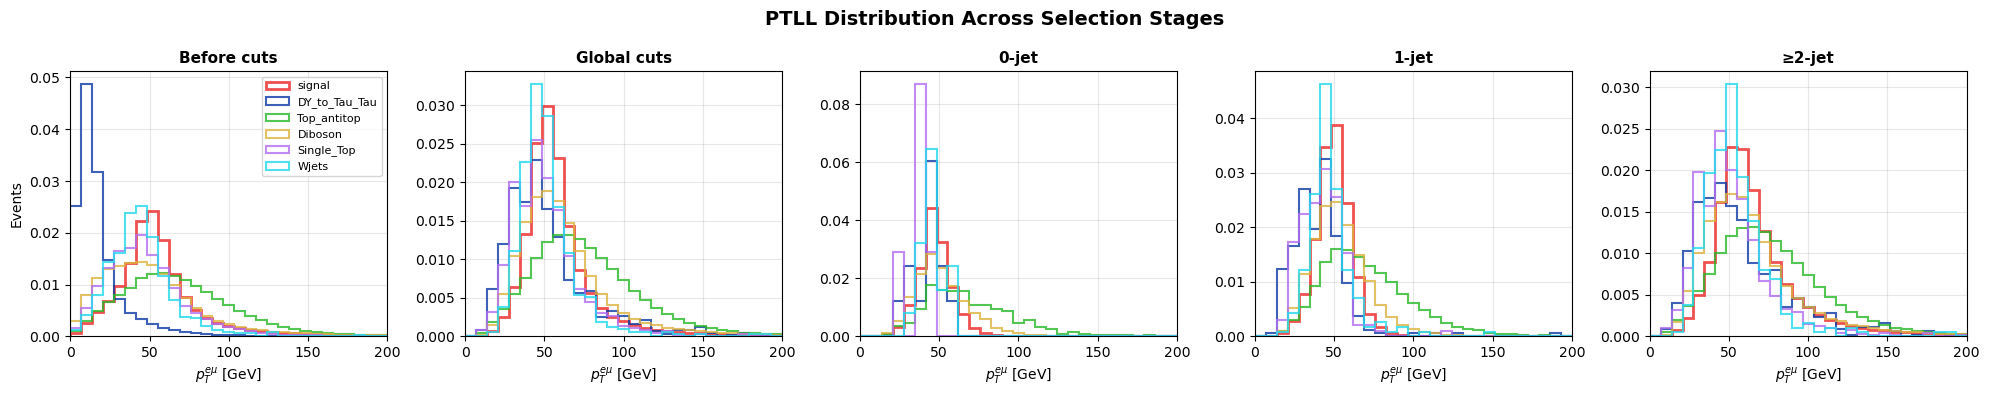


Plotting mt_higgs...


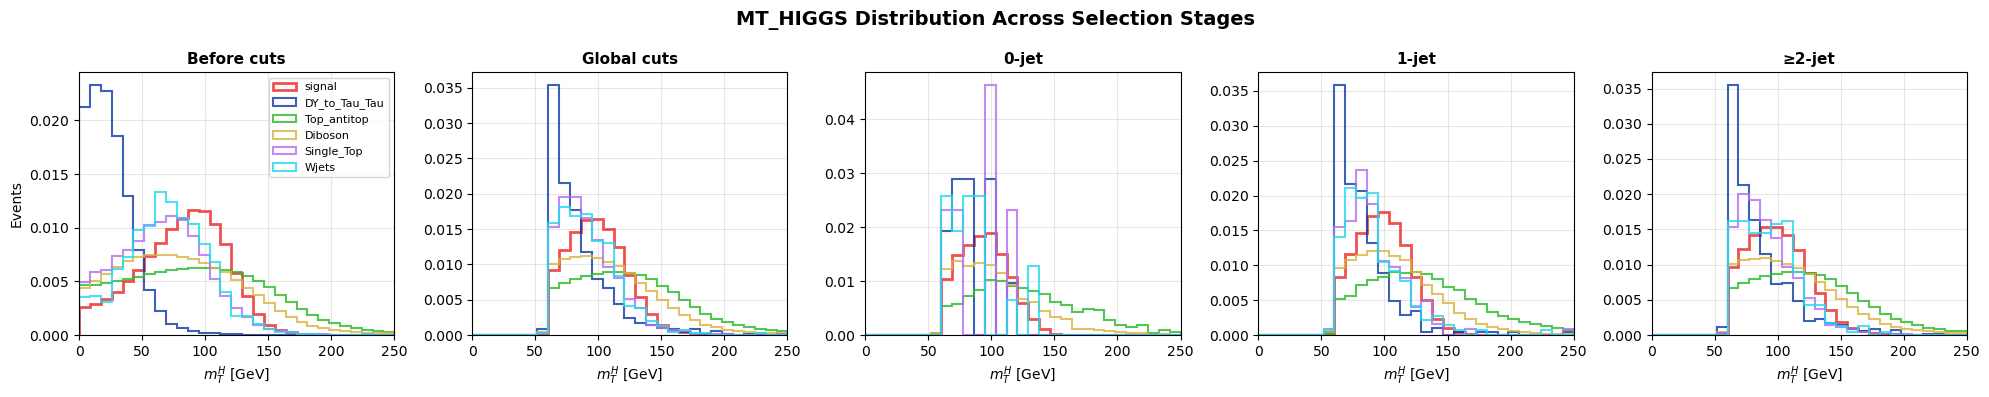


Plotting mt_l2_met...


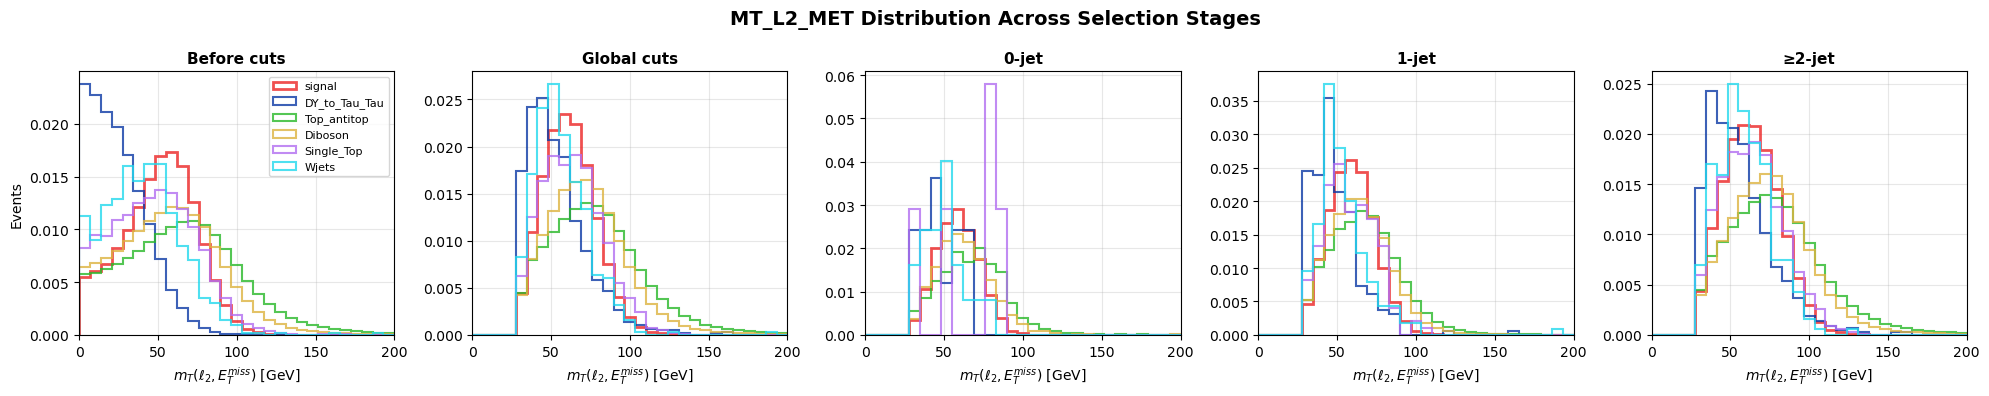

In [30]:
# Plot comparisons for key variables
print("\n" + "="*60)
print("Creating comparison plots...")
print("="*60)

# Plot all variables with signal and backgrounds superimposed
for var_name, var_props in variables_to_plot.items():
    print(f"\nPlotting {var_name}...")
    fig = plot_stage_comparison(var_name, var_props, stage_data_final)
    plt.show()

In [31]:
def get_backgrounds_and_signal():
    """Get ordered backgrounds and signal for plotting"""
    backgrounds = [key for key, props in SAMPLES.items() 
                  if not props["is_signal"] and props["stack_order"] is not None]
    backgrounds.sort(key=lambda x: SAMPLES[x]["stack_order"])
    
    signal = [key for key, props in SAMPLES.items() if props["is_signal"]]
    
    return backgrounds, signal[0] if signal else None

In [45]:
def plot_stage_comparison_stacked(variable, var_props, stage_data_all):
    """Create comparison plot across selection stages with stacked backgrounds and overlaid signal"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Before cuts', 'Global cuts', '0-jet', '1-jet', '≥2-jet']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    # Get backgrounds and signal
    backgrounds, signal = get_backgrounds_and_signal()
    
    for idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
        ax = axes[idx]
        
        # Collect background data
        bkg_data = []
        bkg_labels = []
        bkg_colors = []
        
        for bkg in backgrounds:
            if bkg in stage_data_all and stage_data_all[bkg][stage] is not None:
                if variable in stage_data_all[bkg][stage]:
                    data = ak.to_numpy(stage_data_all[bkg][stage][variable])
                    if len(data) > 0:
                        bkg_data.append(data)
                        bkg_labels.append(bkg)
                        bkg_colors.append(SAMPLES[bkg]["color"])
        
        # Plot stacked backgrounds
        if bkg_data:
            ax.hist(bkg_data, bins=var_props['bins'], label=bkg_labels,
                   color=bkg_colors, stacked=True, alpha=0.7)
        
        # Plot signal on top
        if signal and signal in stage_data_all and stage_data_all[signal][stage] is not None:
            if variable in stage_data_all[signal][stage]:
                sig_data = ak.to_numpy(stage_data_all[signal][stage][variable])
                if len(sig_data) > 0:
                    ax.hist(sig_data, bins=var_props['bins'], 
                           histtype='step', linewidth=2.5, 
                           label='Signal', color=SAMPLES[signal]["color"])
        
        ax.set_xlabel(var_props['xlabel'], fontsize=10)
        ax.set_title(stage_label, fontsize=11, fontweight='bold')
        ax.set_xlim(var_props['xlim'])
        ax.set_yscale('log')
        ax.set_ylim(bottom=1)  # Set a minimum y-limit for log scale

   
        
        if idx == 0:
            ax.set_ylabel('Events', fontsize=10)
            ax.legend(fontsize=8)
        
        ax.grid(True, alpha=0.3)

    
    plt.suptitle(f'{variable.upper()} Distribution Across Selection Stages', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


Creating comparison plots...

Plotting mass...


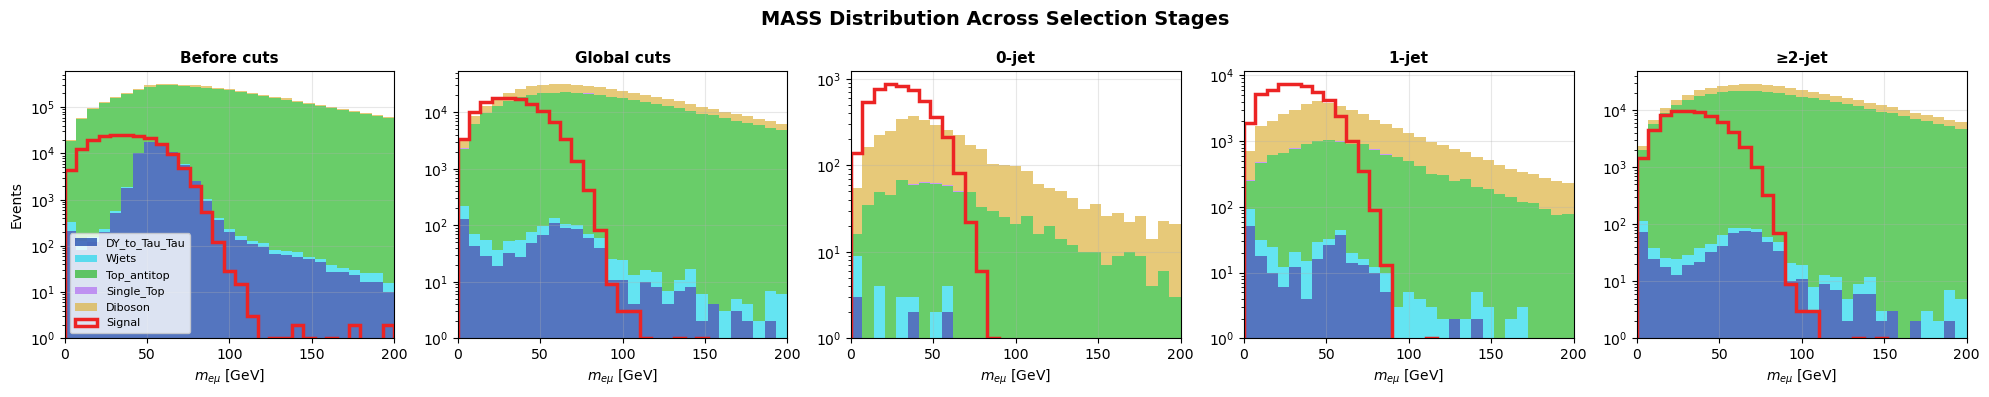


Plotting met...


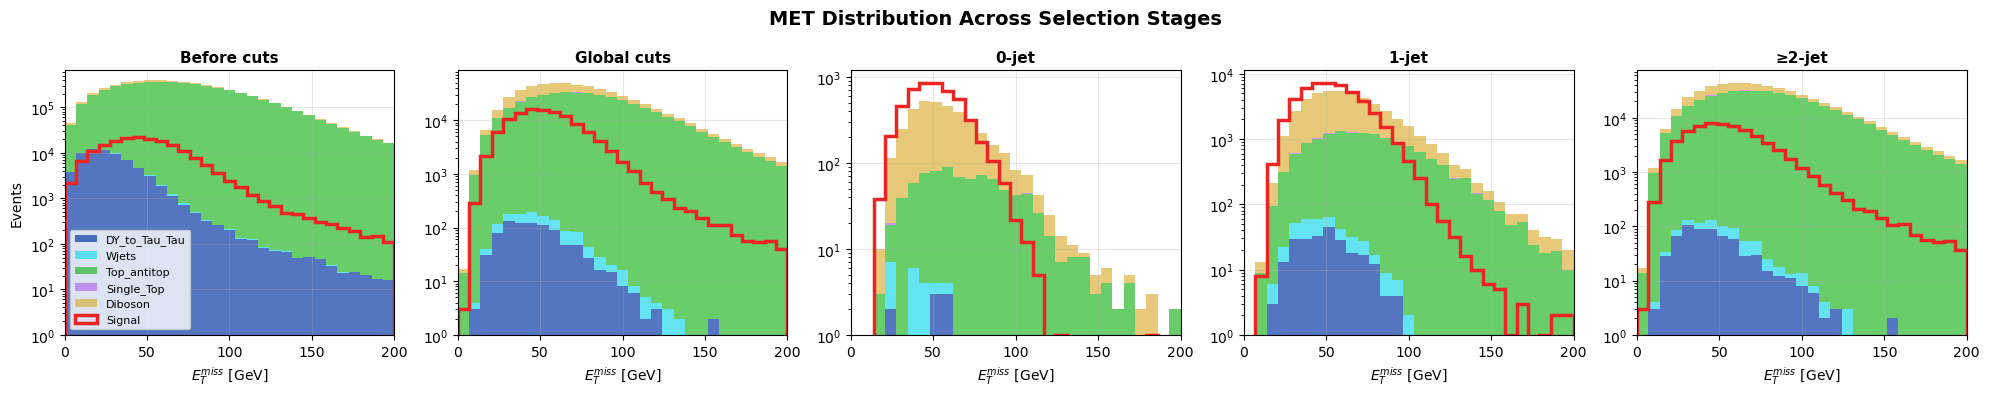


Plotting dphi...


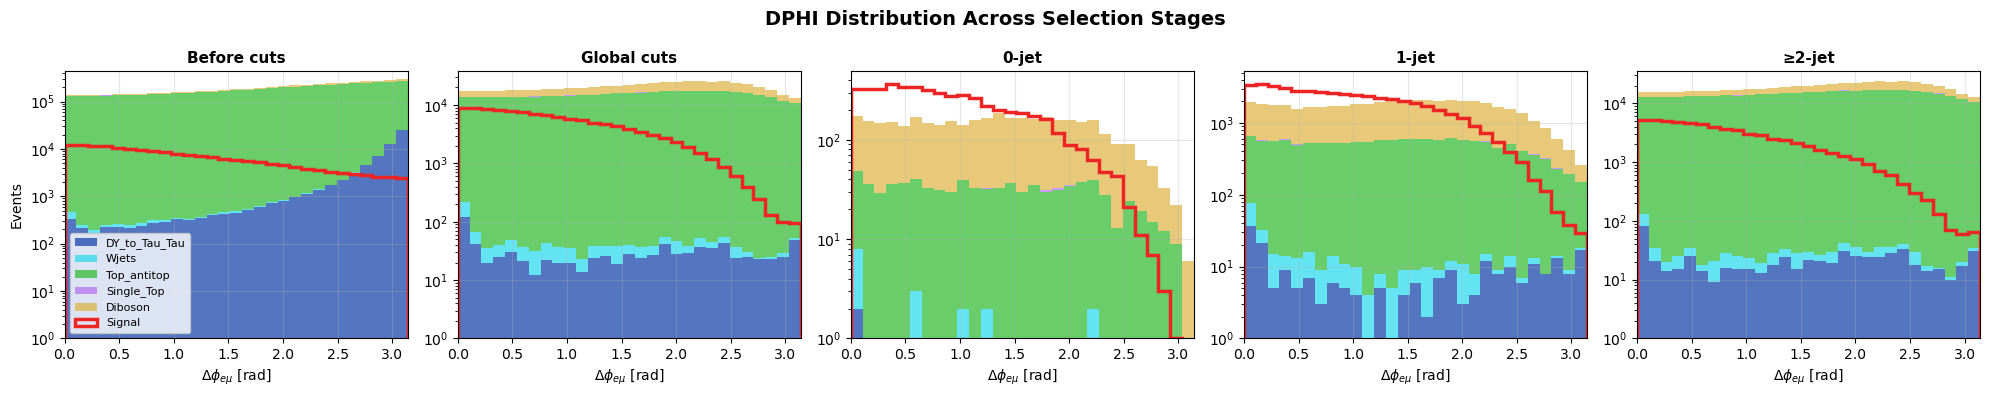


Plotting ptll...


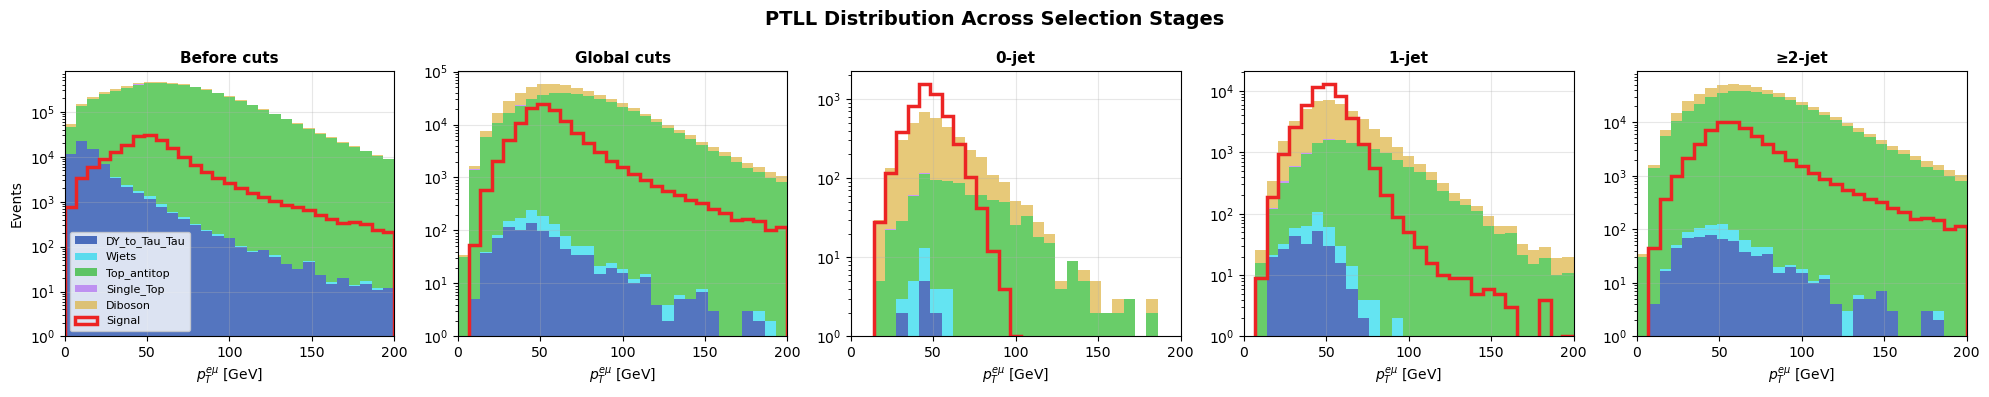


Plotting mt_higgs...


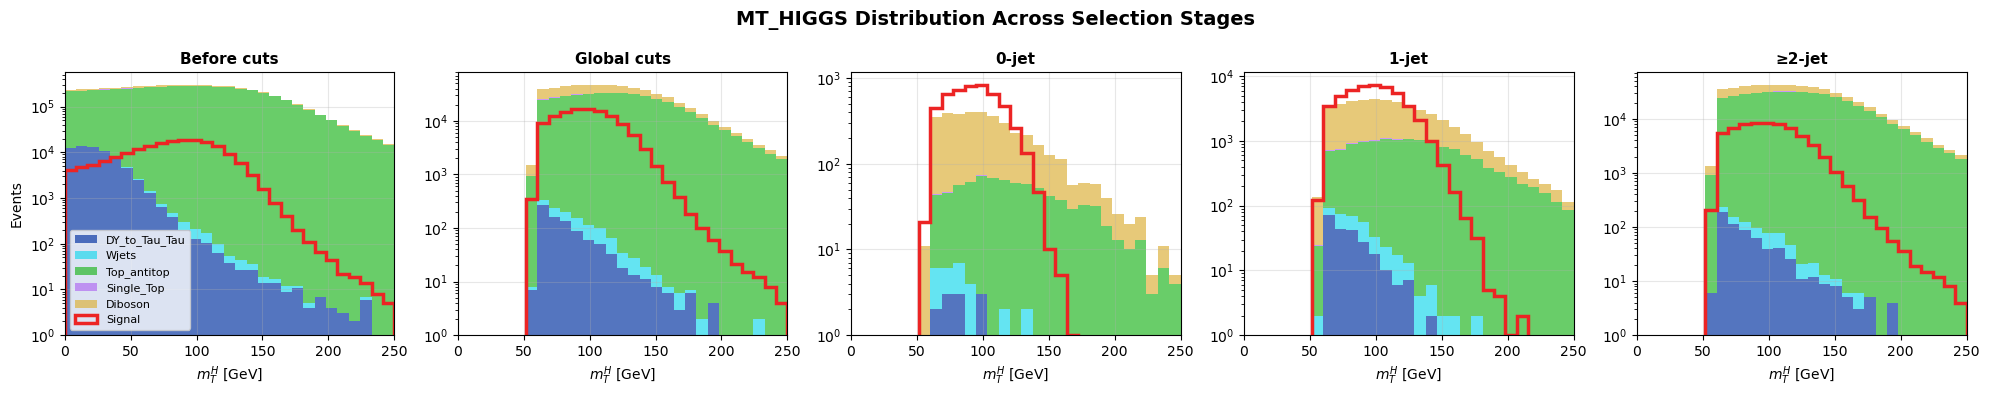


Plotting mt_l2_met...


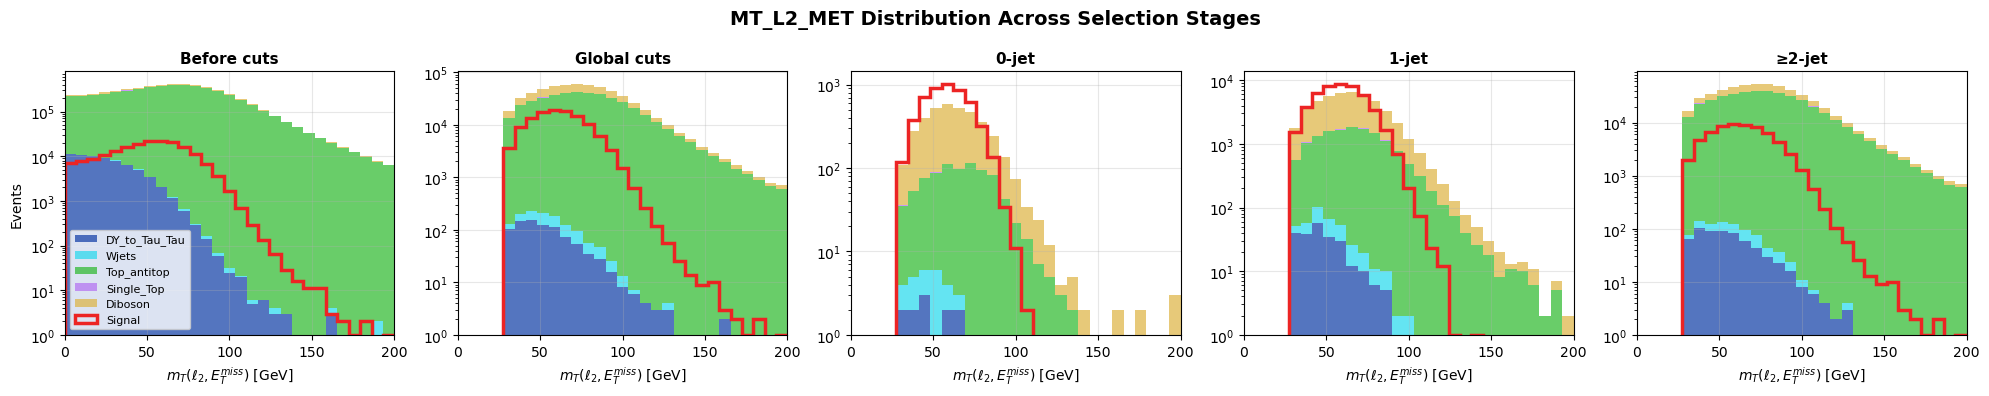

In [46]:
# Plot comparisons with both styles
print("\n" + "="*60)
print("Creating comparison plots...")
print("="*60)

for var_name, var_props in variables_to_plot.items():
    print(f"\nPlotting {var_name}...")
    
    # Step histograms (overlaid)
    # fig1 = plot_stage_comparison(var_name, var_props, stage_data_final)
    # plt.show()
    
    # Stacked backgrounds with signal overlay
    fig2 = plot_stage_comparison_stacked(var_name, var_props, stage_data_final)
    plt.show()

---
---
---
---
# Extras
---
---
---
---
---


In [47]:
def plot_overlaid_stages(variable, var_props, all_samples_data):
    """Create overlaid histograms for all stages in single plot per sample"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Before cuts', 'Global cuts', '0-jet', '1-jet', '≥2-jet']
    stage_colors = ['#666666', '#0066CC', '#00AA44', '#FF9900', '#CC0000']
    stage_styles = ['-', '--', '-.', ':', '-']
    
    # Create subplot for each sample
    n_samples = len(all_samples_data)
    n_cols = min(3, n_samples)
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_samples == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (sample_label, sample_data) in enumerate(all_samples_data.items()):
        ax = axes[idx] if n_samples > 1 else axes[0]
        
        for stage_idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
            if sample_data[stage] is not None and variable in sample_data[stage]:
                data = ak.to_numpy(sample_data[stage][variable])
                
                if len(data) > 0:
                    # Create histogram
                    h = Hist.new.Var(var_props['bins'], name="var").Double()
                    h.fill(var=data)
                    
                    # Plot as step histogram
                    h.plot(ax=ax, histtype="step", 
                          label=f'{stage_label} ({len(data):,})',
                          color=stage_colors[stage_idx],
                          linestyle=stage_styles[stage_idx],
                          linewidth=2, density=True, yerr=False)
        
        ax.set_xlabel(var_props['xlabel'], fontsize=11)
        ax.set_ylabel('Normalized events', fontsize=11)
        ax.set_title(f'{sample_label}', fontsize=12, fontweight='bold')
        ax.set_xlim(var_props['xlim'])
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    # Hide extra subplots if any
    for idx in range(n_samples, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle(f'{variable.upper()} Distribution: Stage Comparison', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig



Creating overlaid plot for mass...


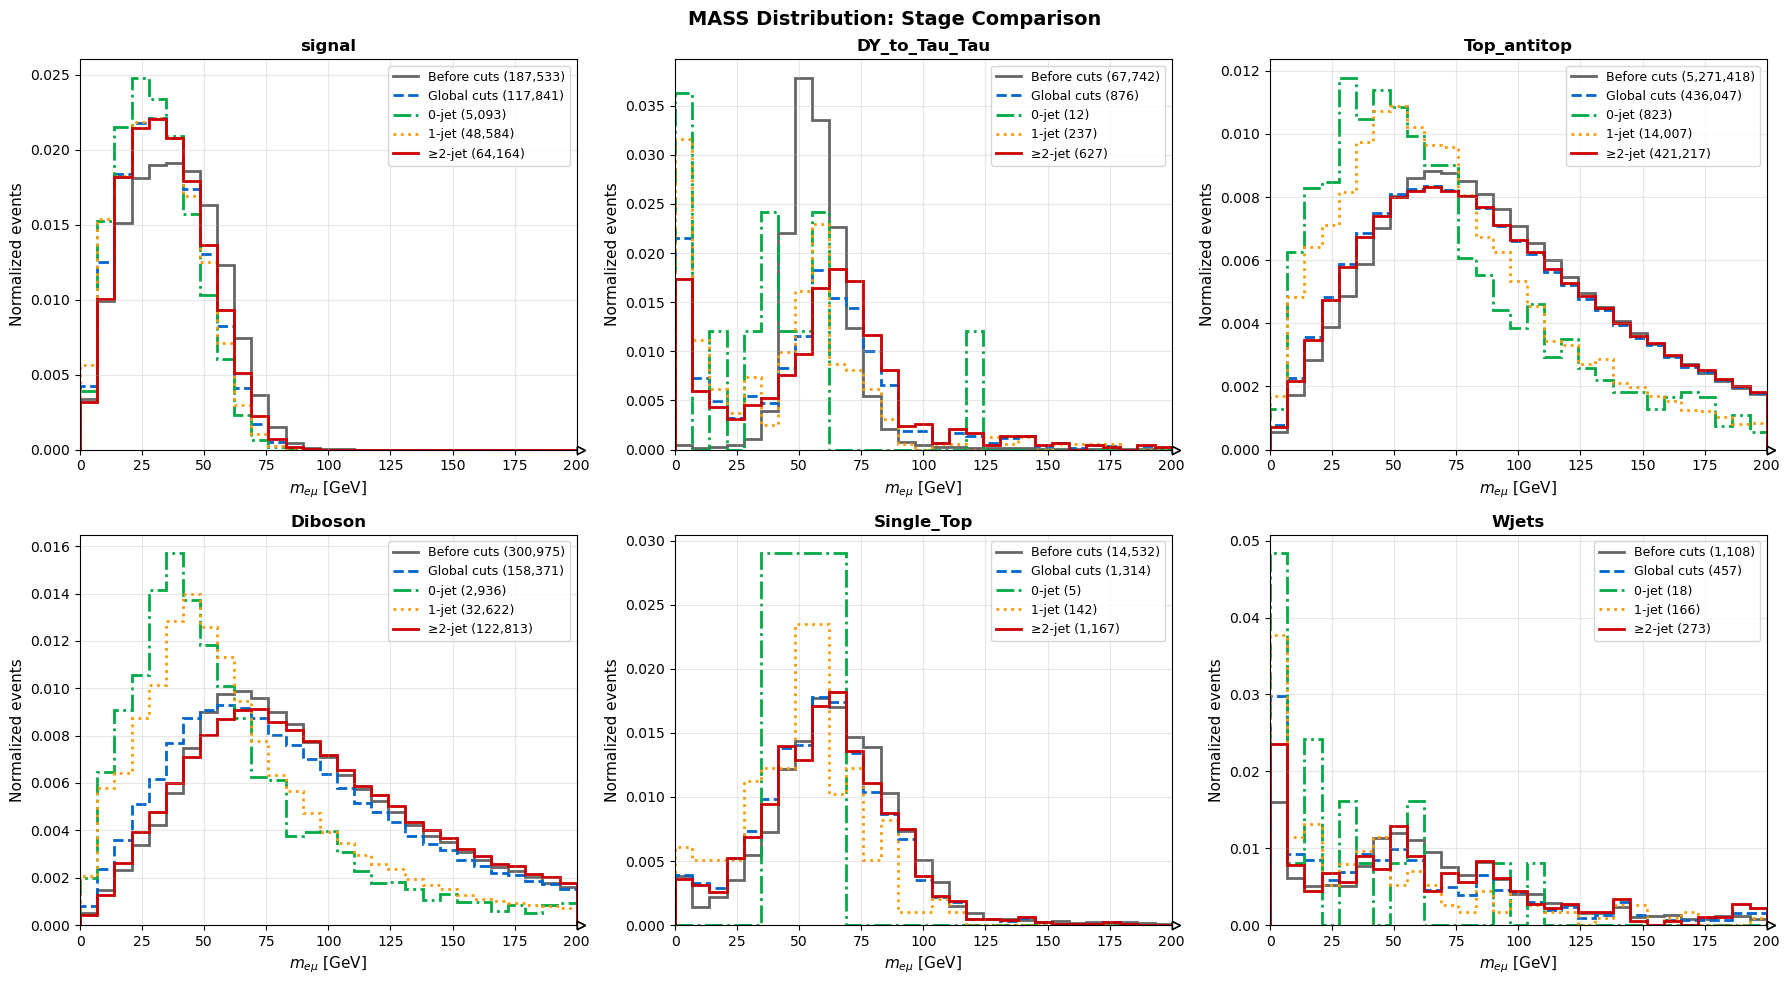


Creating overlaid plot for mt_higgs...


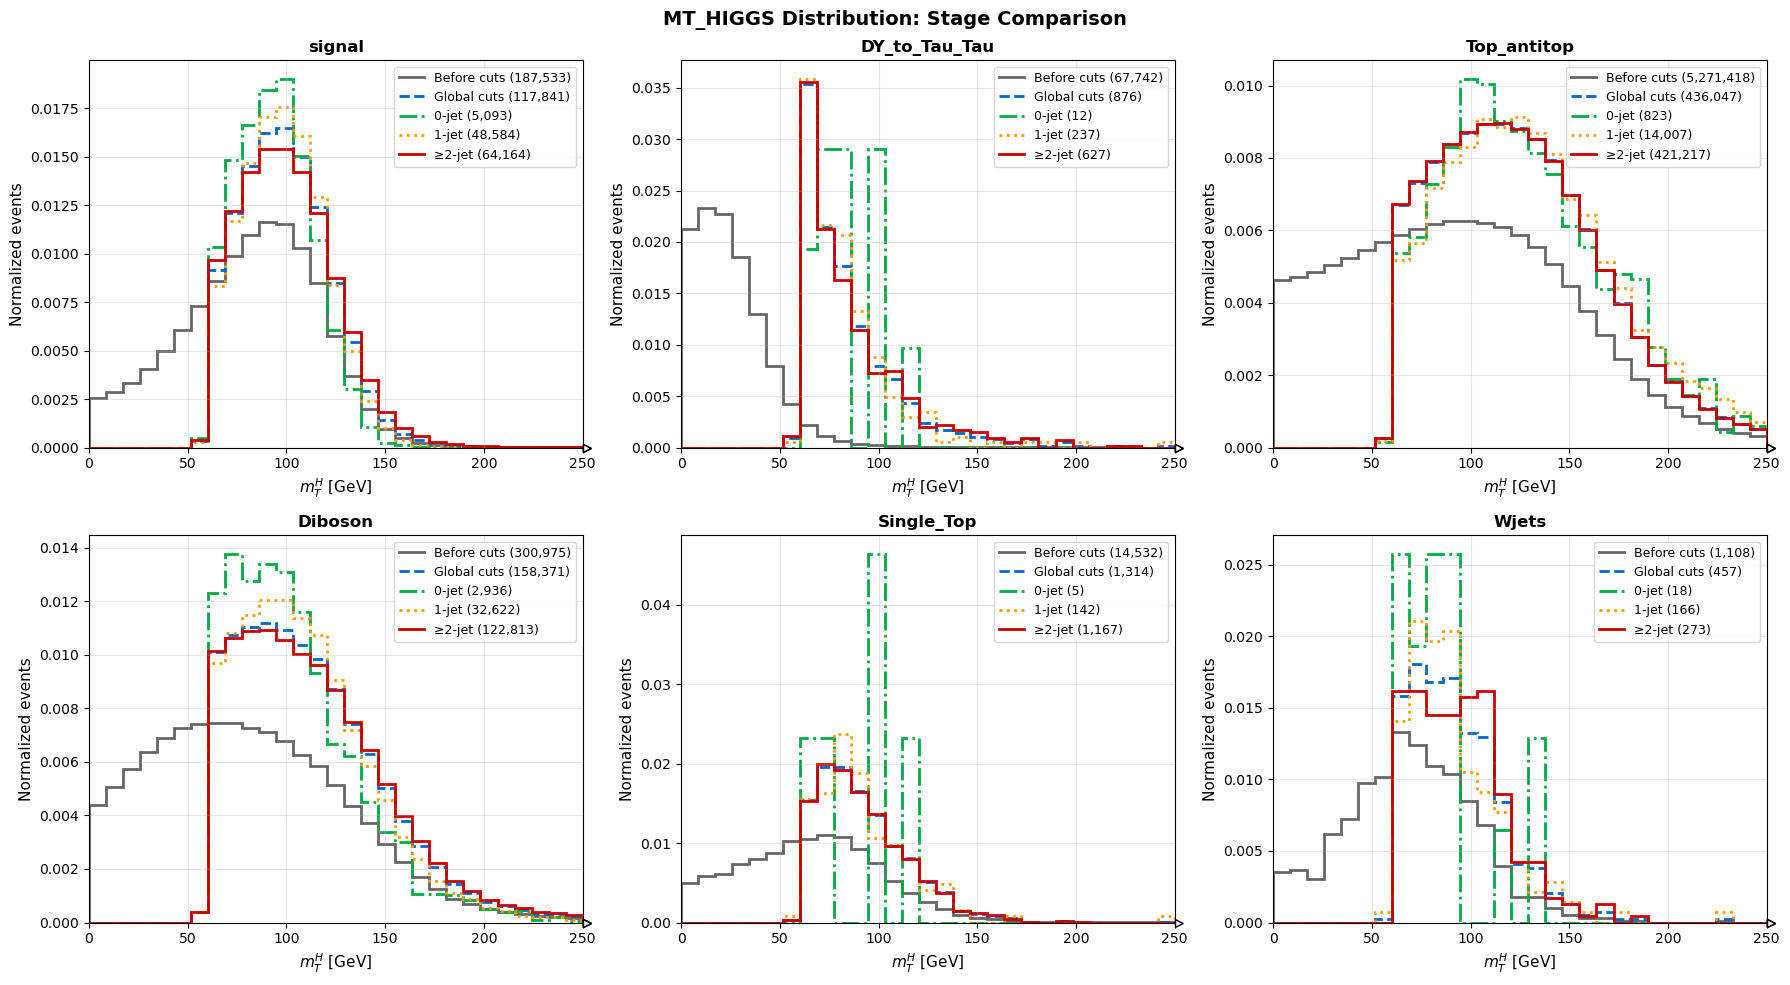


Creating overlaid plot for dphi...


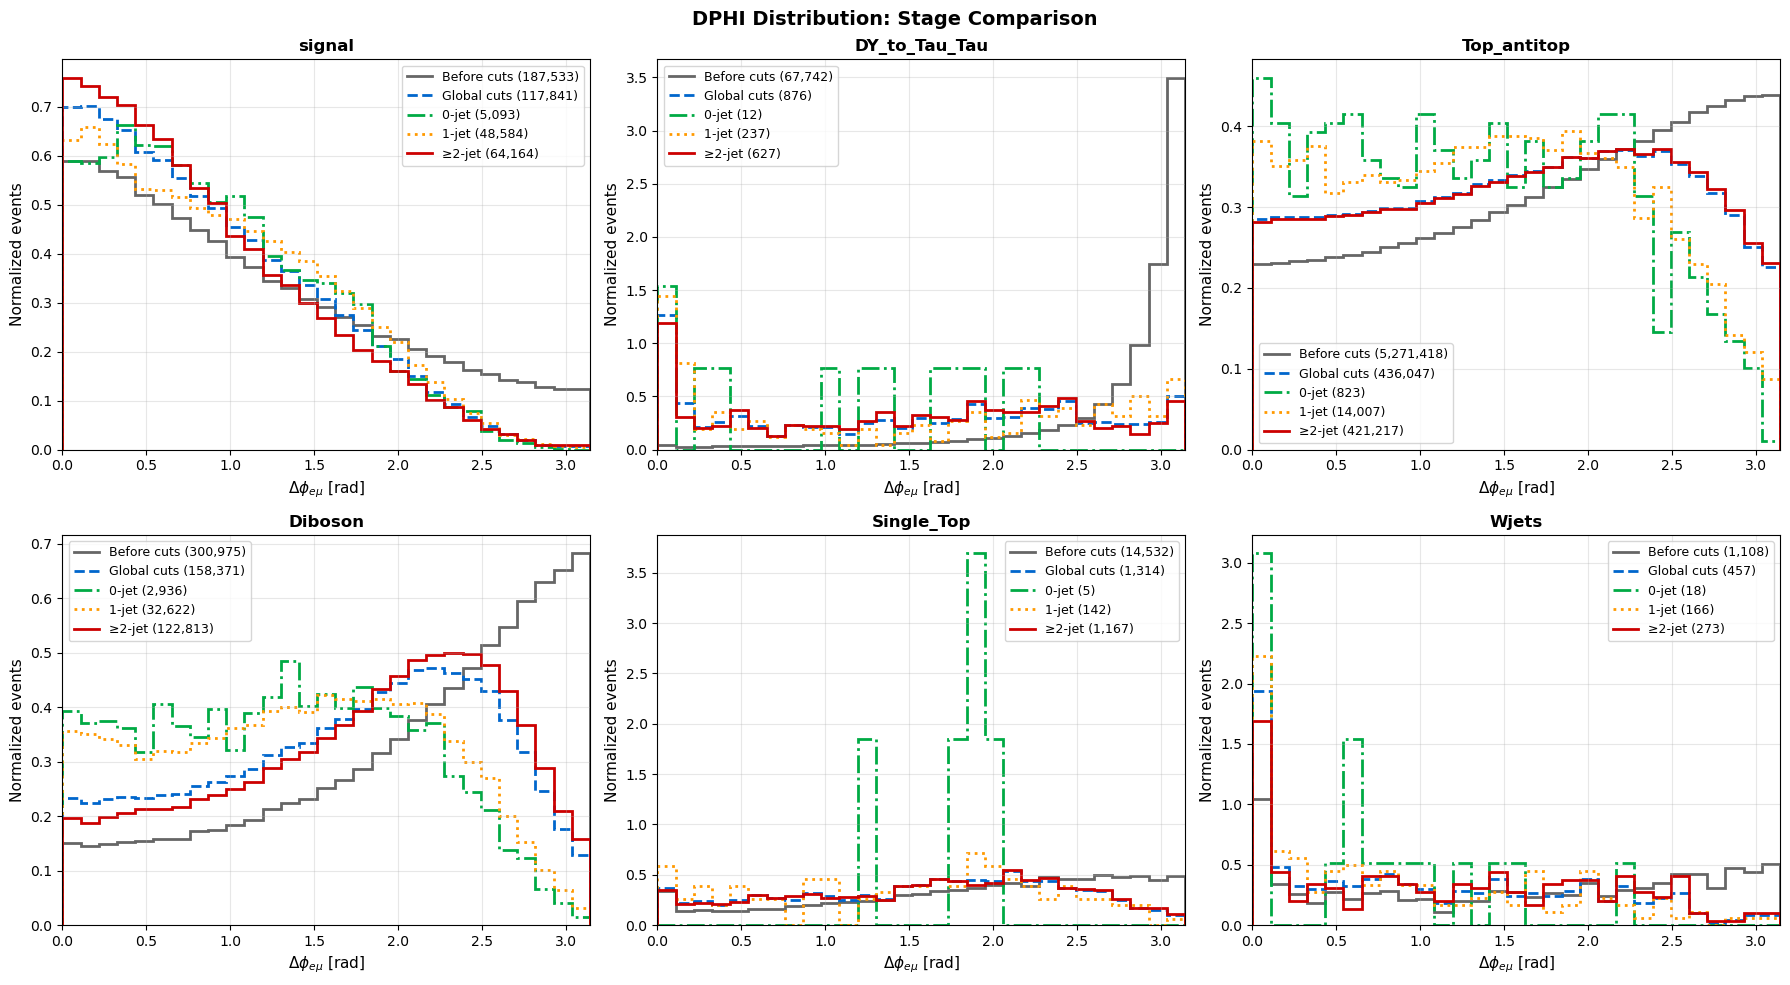


Creating overlaid plot for ptll...


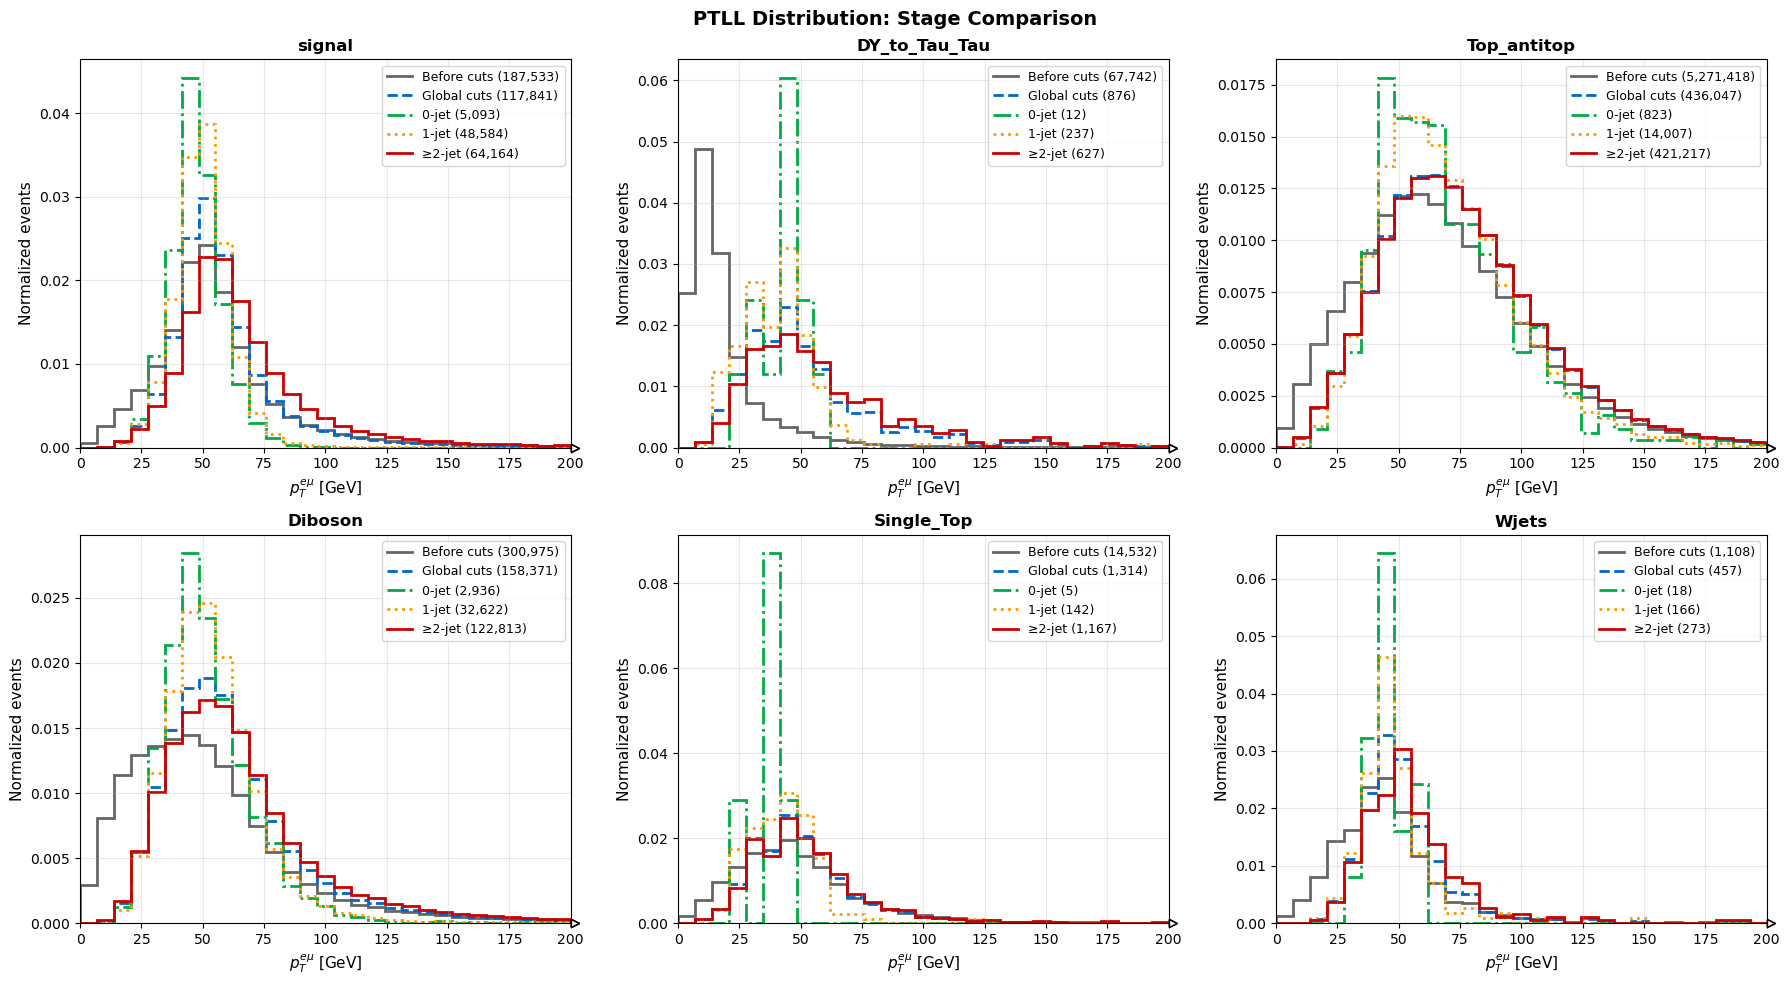


Creating overlaid plot for met...


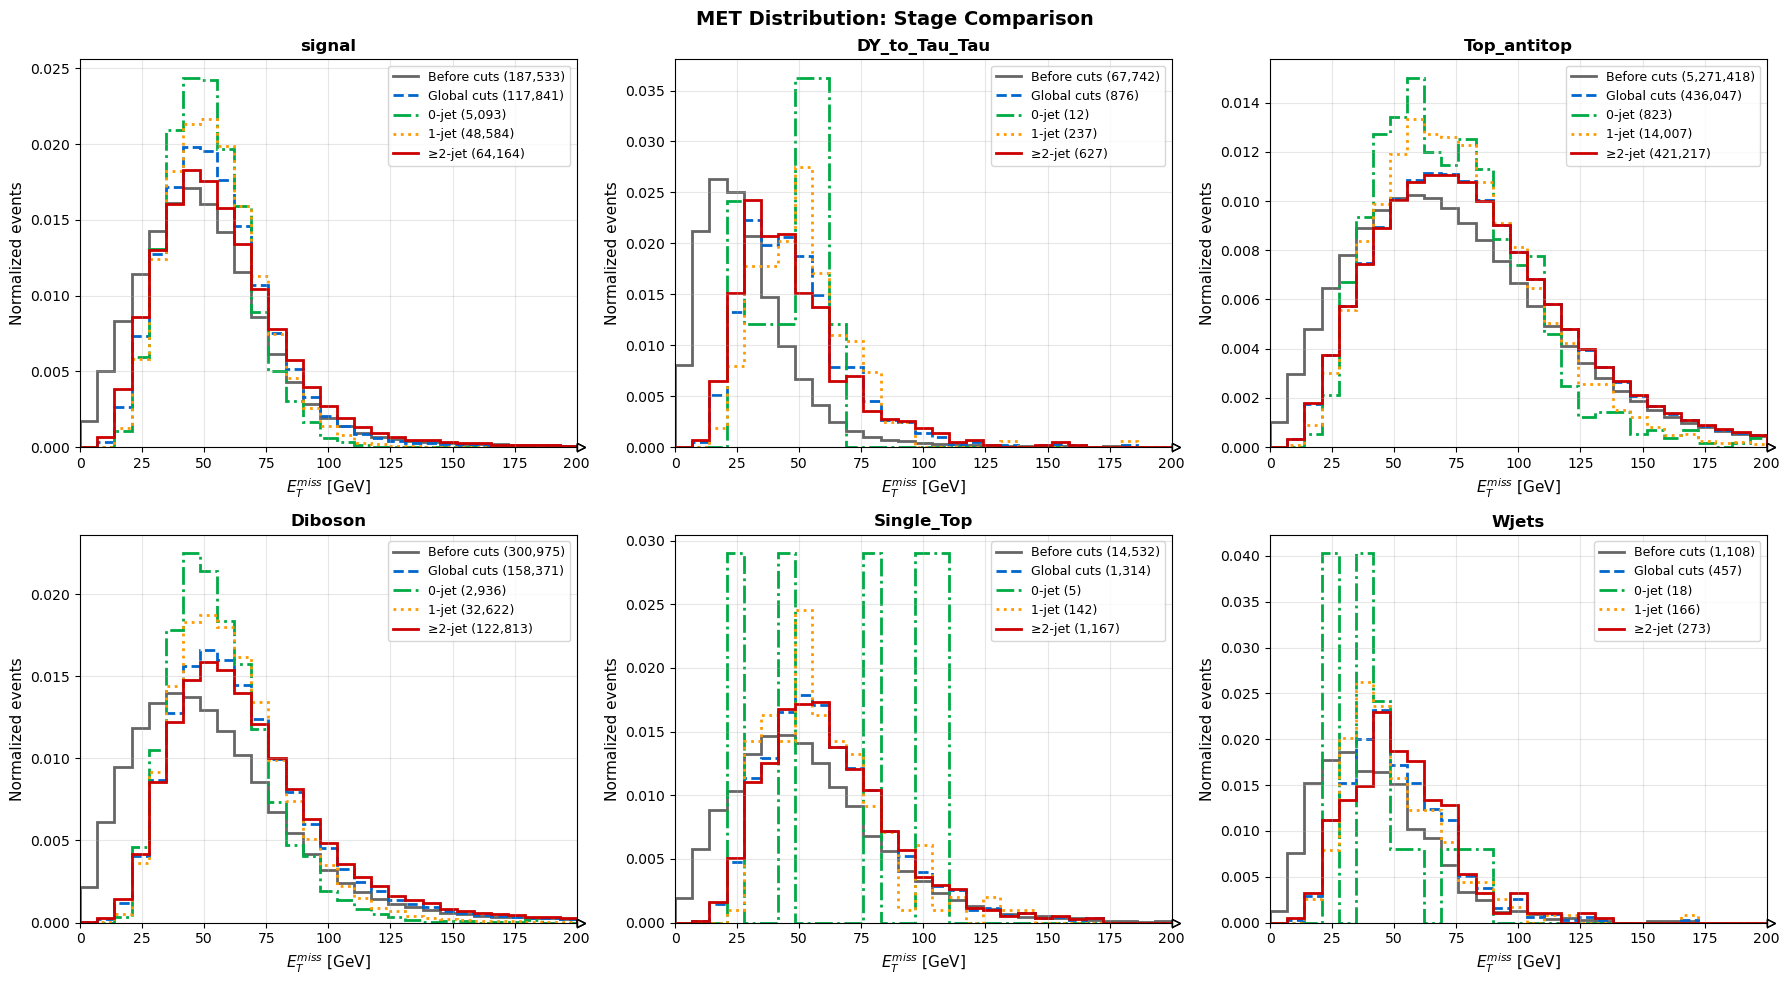


Creating overlaid plot for mt_l2_met...


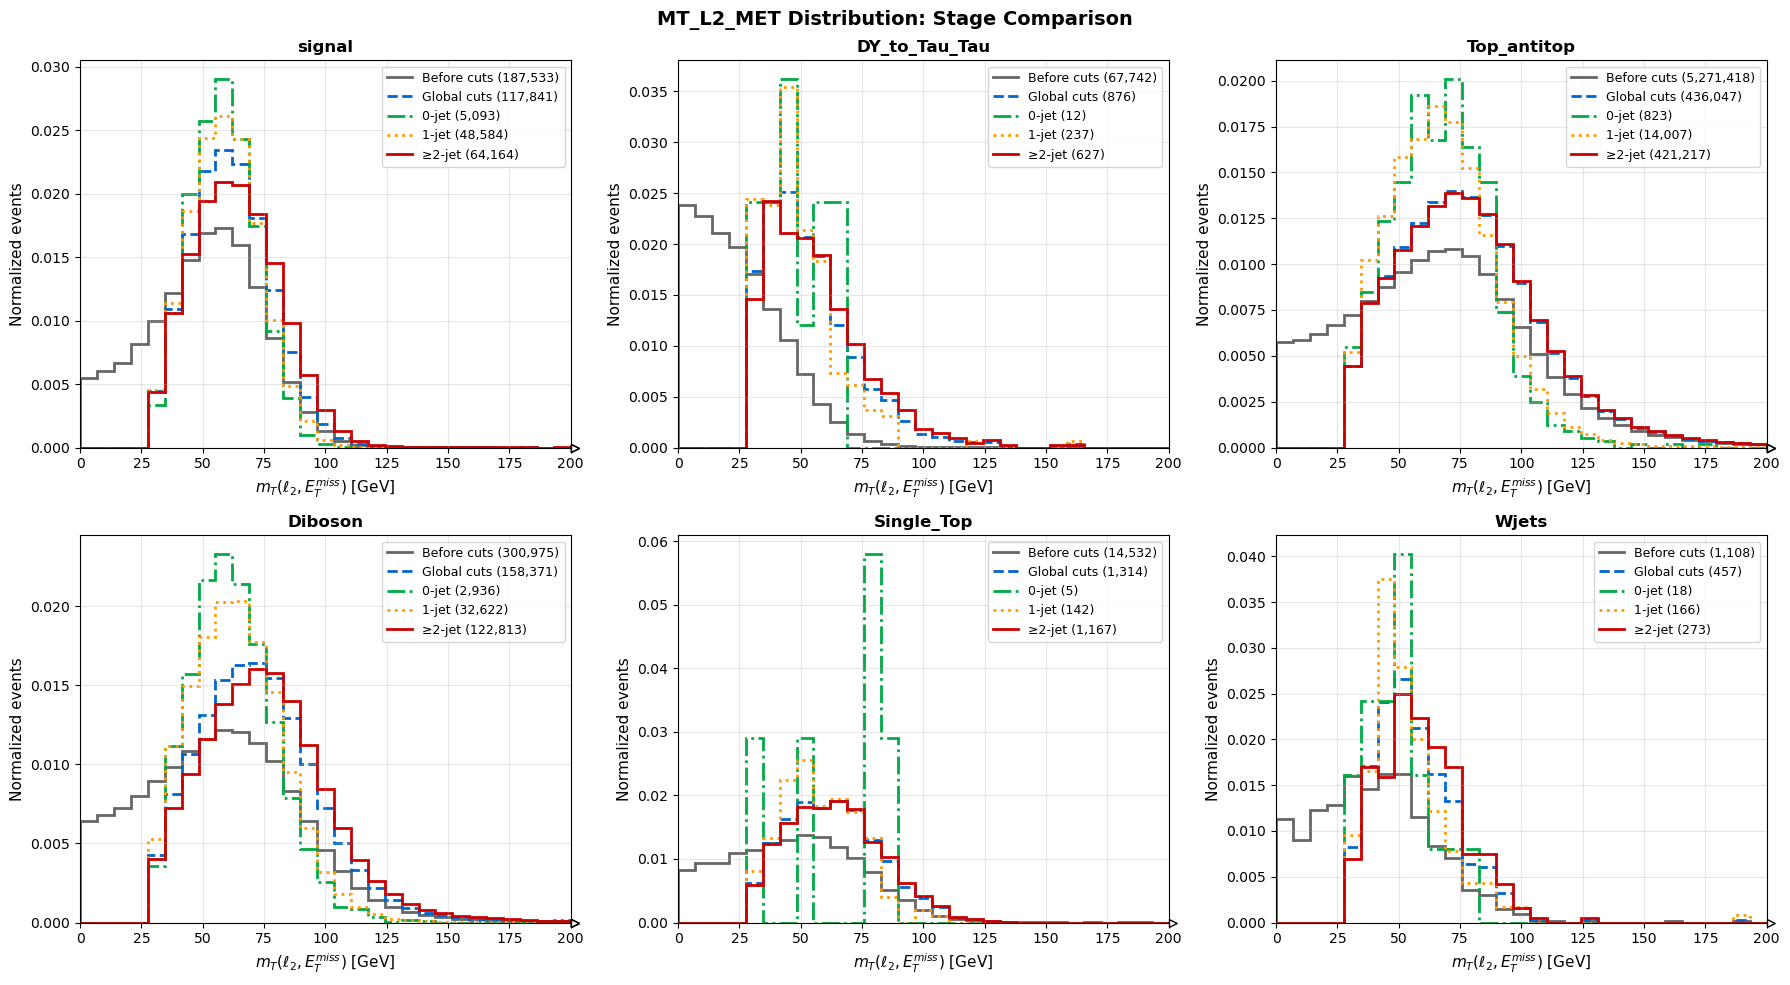

In [51]:
# Create overlaid plots for key variables
key_variables = ['mass', 'mt_higgs', 'dphi','ptll', 'met', 'mt_l2_met']

for var_name in key_variables:
    if var_name in variables_to_plot:
        print(f"\nCreating overlaid plot for {var_name}...")
        fig = plot_overlaid_stages(var_name, variables_to_plot[var_name], 
                                  stage_data_final)
        plt.show()

In [49]:
# Summary statistics table
def print_event_statistics(all_samples_data):
    """Print summary statistics for all samples and stages"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Before cuts', 'Global cuts', '0-jet', '1-jet', '≥2-jet']
    
    print("\n" + "="*80)
    print("EVENT STATISTICS SUMMARY")
    print("="*80)
    
    # Create header
    header = f"{'Sample':<15} | " + " | ".join([f"{s:<12}" for s in stage_labels])
    print(header)
    print("-" * len(header))
    
    # Print statistics for each sample
    for sample_label in all_samples_data.keys():
        row = f"{sample_label:<15} | "
        
        for stage in stages:
            if (all_samples_data[sample_label][stage] is not None and 
                'mass' in all_samples_data[sample_label][stage]):
                n_events = len(all_samples_data[sample_label][stage]['mass'])
                row += f"{n_events:>12,} | "
            else:
                row += f"{'0':>12} | "
        
        print(row.rstrip(' |'))
    
    print("="*80)
    
    # Calculate total backgrounds and signal
    print("\nSUMMARY:")
    print("-"*40)
    
    for stage, stage_label in zip(stages, stage_labels):
        total_bkg = 0
        total_sig = 0
        
        for sample_label, sample_props in SAMPLES.items():
            if sample_label in all_samples_data:
                if (all_samples_data[sample_label][stage] is not None and
                    'mass' in all_samples_data[sample_label][stage]):
                    n_events = len(all_samples_data[sample_label][stage]['mass'])
                    
                    if sample_props["is_signal"]:
                        total_sig += n_events
                    else:
                        total_bkg += n_events
        
        print(f"{stage_label:<15}: Signal = {total_sig:>8,}, Background = {total_bkg:>10,}")
        if total_bkg > 0:
            print(f"{'':>15}  S/√B = {total_sig/np.sqrt(total_bkg):>6.2f}")

# Print the statistics
print_event_statistics(stage_data_final)



EVENT STATISTICS SUMMARY
Sample          | Before cuts  | Global cuts  | 0-jet        | 1-jet        | ≥2-jet      
------------------------------------------------------------------------------------------
signal          |      187,533 |      117,841 |        5,093 |       48,584 |       64,164
DY_to_Tau_Tau   |       67,742 |          876 |           12 |          237 |          627
Top_antitop     |    5,271,418 |      436,047 |          823 |       14,007 |      421,217
Diboson         |      300,975 |      158,371 |        2,936 |       32,622 |      122,813
Single_Top      |       14,532 |        1,314 |            5 |          142 |        1,167
Wjets           |        1,108 |          457 |           18 |          166 |          273

SUMMARY:
----------------------------------------
Before cuts    : Signal =  187,533, Background =  5,655,775
                 S/√B =  78.86
Global cuts    : Signal =  117,841, Background =    597,065
                 S/√B = 152.51
0-jet        

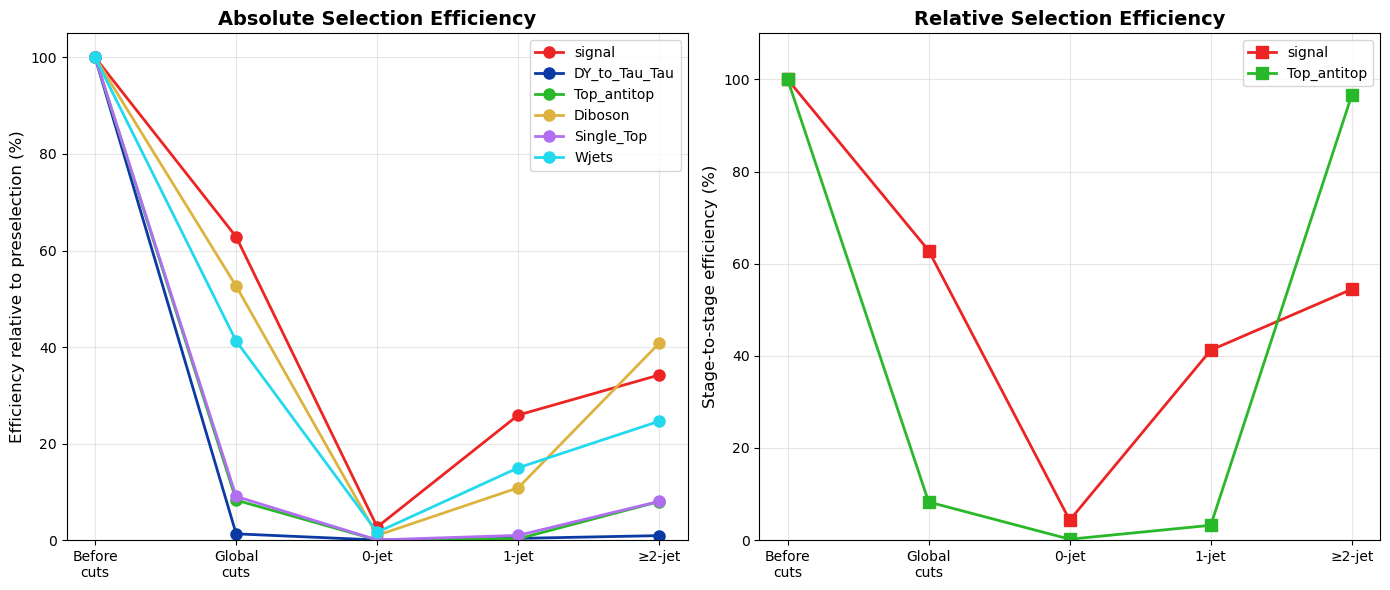


Analysis complete!


In [50]:
def plot_selection_efficiency(all_samples_data):
    """Plot selection efficiency across stages"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Before\ncuts', 'Global\ncuts', '0-jet', '1-jet', '≥2-jet']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Calculate efficiencies
    for sample_label in all_samples_data.keys():
        if all_samples_data[sample_label]['before_cuts'] is not None:
            n_initial = len(all_samples_data[sample_label]['before_cuts']['mass'])
            
            if n_initial > 0:
                efficiencies = []
                for stage in stages:
                    if (all_samples_data[sample_label][stage] is not None and
                        'mass' in all_samples_data[sample_label][stage]):
                        n_events = len(all_samples_data[sample_label][stage]['mass'])
                        efficiencies.append(100 * n_events / n_initial)
                    else:
                        efficiencies.append(0)
                
                # Absolute efficiency
                ax1.plot(range(len(stages)), efficiencies,
                        marker='o', markersize=8,
                        label=sample_label,
                        color=SAMPLES[sample_label]["color"],
                        linewidth=2)
                
                # Relative efficiency (stage-to-stage)
                if sample_label in ['signal', 'Top_antitop']:  # Focus on key samples
                    relative_eff = []
                    for i, stage in enumerate(stages):
                        if i == 0:
                            relative_eff.append(100)
                        elif i <= 2:  # Up to global cuts
                            prev_stage = stages[i-1]
                            n_prev = len(all_samples_data[sample_label][prev_stage]['mass'])
                            n_curr = len(all_samples_data[sample_label][stage]['mass'])
                            if n_prev > 0:
                                relative_eff.append(100 * n_curr / n_prev)
                            else:
                                relative_eff.append(0)
                        else:  # Jet categories relative to global
                            n_global = len(all_samples_data[sample_label]['global']['mass'])
                            n_curr = len(all_samples_data[sample_label][stage]['mass'])
                            if n_global > 0:
                                relative_eff.append(100 * n_curr / n_global)
                            else:
                                relative_eff.append(0)
                    
                    ax2.plot(range(len(stages)), relative_eff,
                            marker='s', markersize=8,
                            label=sample_label,
                            color=SAMPLES[sample_label]["color"],
                            linewidth=2)
    
    # Format absolute efficiency plot
    ax1.set_xticks(range(len(stages)))
    ax1.set_xticklabels(stage_labels)
    ax1.set_ylabel('Efficiency relative to preselection (%)', fontsize=12)
    ax1.set_title('Absolute Selection Efficiency', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)
    
    # Format relative efficiency plot
    ax2.set_xticks(range(len(stages)))
    ax2.set_xticklabels(stage_labels)
    ax2.set_ylabel('Stage-to-stage efficiency (%)', fontsize=12)
    ax2.set_title('Relative Selection Efficiency', fontsize=14, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 110)
    
    plt.tight_layout()
    return fig

# Create efficiency plot
fig = plot_selection_efficiency(stage_data_final)
plt.show()

print("\n" + "="*60)
print("Analysis complete!")
print("="*60)